In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel
from scipy.stats import ttest_ind

import os
import glob
import numpy as np 

In [20]:
PATH = 'data/'

In [21]:
data_list = ['singh', 'west']

In [22]:
p = os.path.abspath(PATH)

datasets = []
for d in data_list:
    csv_files = glob.glob(os.path.join(p, f'batch_{d}.csv'))
    for csv_file in csv_files:
        dataset = pd.read_csv(csv_file)
        datasets.append(dataset)
test = datasets[1]
test.head()

,dataset,_wrapper,num_features_algo,fs_method1,fs_method2,fs_method1_cv_mean,fs_method2_cv_mean,p_value,winner
0,christensen,DT,5,InfoGain,SPFSR,0.017286,0.0,0.000,SPFSR
1,christensen,DT,5,FScore,SPFSR,0.000466,0.0,0.158,tie
2,christensen,DT,5,MRMR,SPFSR,0.211169,0.0,0.000,SPFSR
3,christensen,DT,5,SFS,SPFSR,0.096625,0.0,0.000,SPFSR
4,christensen,DT,5,GA,SPFSR,0.028806,0.0,0.000,SPFSR


In [23]:
print(type(dataset))

<class 'pandas.core.frame.DataFrame'>


In [24]:
unique_datasets = datasets[0]['dataset'].unique()
unique_datasets1 = datasets[1]['dataset'].unique()
u_dataset = np.append(unique_datasets, unique_datasets1)
print(u_dataset)

['sun' 'subramanian' 'shipp' 'su' 'singh' 'christensen' 'pomeroy' 'alon'
 'nakayama' 'tian' 'chin' 'chowdary' 'chiaretti' 'golub' 'gordon' 'khan'
 'gravier' 'borovecki' 'west']


In [25]:
individual_dataframes = []
for d in datasets:
    # Split the DataFrame into individual DataFrames based on unique datasets
    for dataset_name in u_dataset:
        individual_df = d[d['dataset'] == dataset_name].copy()
        individual_dataframes.append(individual_df)


In [26]:
fs_methods = datasets[0]['fs_method2'].unique()
fs_winner = datasets[1]['winner'].unique()
fs_wrapper = datasets[1]['_wrapper'].unique()

extra_method = 'InfoGain'
fr_methods = np.append(fs_methods, extra_method)

print(fr_methods)
print(fs_winner)
print(fs_wrapper)

['SPFSR' 'InfoGain']
['SPFSR' 'tie' 'InfoGain' 'FScore' 'MRMR' 'SFS' 'GA' 'RFI' 'ReliefF' 'CFS']
['DT']


In [27]:
result = pd.concat([datasets[0], datasets[1]], ignore_index=True)
print(result['dataset'].unique())

['sun' 'subramanian' 'shipp' 'su' 'singh' 'christensen' 'pomeroy' 'alon'
 'nakayama' 'tian' 'chin' 'chowdary' 'chiaretti' 'golub' 'gordon' 'khan'
 'gravier' 'borovecki' 'west']


In [32]:
count = len(result[(result['fs_method1'] == 'FScore') & (result['fs_method2'] == 'SPFSR') & ((result['winner'] == 'SPFSR') | (result['winner'] == 'FScore'))])
print(count)

74


In [33]:
# List of unique methods excluding 'SPFSR'
fr_methods = result['fs_method1'].unique()

# Create an empty dictionary to store summaries for each method
method_summaries = {}

# Initialize FScore counters
fscore_wins = 0
fscore_ties = 0

# Iterate over each dataset in 'result'
for dataset_group in result.groupby('dataset'):
    # Extract the DataFrame from the tuple
    dataset_group = dataset_group[1]
    
    # Initialize counts for SPFSR
    spfsr_wins = 0
    spfsr_ties = 0
    spfsr_losses = 0
    
    # Iterate over unique methods
    for method in fr_methods:
        winner = 0
        tie = 0
        loss = 0

        for index, row in dataset_group.iterrows():
            if row['fs_method1'] == 'SPFSR' and row['fs_method2'] == 'SPFSR':
                continue

            if row['fs_method1'] == 'SPFSR' and row['fs_method2'] == method:
                if row['winner'] == 'SPFSR':
                    winner += 1
                elif row['winner'] == 'tie':
                    tie += 1
                else:
                    loss += 1

            if row['fs_method1'] == method and row['fs_method2'] == 'SPFSR':
                if row['winner'] == 'SPFSR':
                    winner += 1
                elif row['winner'] == 'tie':
                    tie += 1
                else:
                    loss += 1

        # Handle 'InfoGain' method
        if method == 'InfoGain':
            for index, row in dataset_group.iterrows():
                if row['fs_method1'] == 'InfoGain' and row['fs_method2'] == 'SPFSR':
                    if row['winner'] == 'SPFSR':
                        winner += 1
                    elif row['winner'] == 'tie':
                        tie += 1
                    else:
                        loss += 1

                if row['fs_method1'] == 'SPFSR' and row['fs_method2'] == 'InfoGain':
                    if row['winner'] == 'SPFSR':
                        winner += 1
                    elif row['winner'] == 'tie':
                        tie += 1
                    else:
                        loss += 1
        
        # Check if FScore wins or ties against SPFSR
        if method == 'FScore':
            fscore_wins += winner
            fscore_ties += tie
    
        else:
            if method in method_summaries:
                method_summaries[method]['winner'] = method_summaries[method].get('winner', 0) + winner
                method_summaries[method]['tie'] = method_summaries[method].get('tie', 0) + tie
                method_summaries[method]['loss'] = method_summaries[method].get('loss', 0) + loss
            else:
                method_summaries[method] = {'winner': winner, 'tie': tie, 'loss': loss}
    
    # Include the counts for SPFSR
    spfsr_summary = {'winner': spfsr_wins, 'tie': spfsr_ties, 'loss': spfsr_losses}
    
    if 'SPFSR' in method_summaries:
        method_summaries['SPFSR']['winner'] = method_summaries['SPFSR'].get('winner', 0) + spfsr_summary['winner']
        method_summaries['SPFSR']['tie'] = method_summaries['SPFSR'].get('tie', 0) + spfsr_summary['tie']
        method_summaries['SPFSR']['loss'] = method_summaries['SPFSR'].get('loss', 0) + spfsr_summary['loss']
    else:
        method_summaries['SPFSR'] = spfsr_summary

# Check if FScore is in method_summaries, and if not, add it
if 'FScore' not in method_summaries:
    method_summaries['FScore'] = {'winner': fscore_wins, 'tie': fscore_ties, 'loss': 0}
else:
    # Add FScore wins and ties to FScore's respective counts and set FScore's loss count to 0
    method_summaries['FScore']['winner'] = method_summaries['FScore'].get('winner', 0) + fscore_wins
    method_summaries['FScore']['tie'] = method_summaries['FScore'].get('tie', 0) + fscore_ties
    method_summaries['FScore']['loss'] = 0

# Print the method summaries
for method, summary in method_summaries.items():
    print(f'{method}: {summary}')


InfoGain: {'winner': 76, 'tie': 18, 'loss': 66}
MRMR: {'winner': 65, 'tie': 2, 'loss': 13}
SFS: {'winner': 60, 'tie': 7, 'loss': 13}
GA: {'winner': 51, 'tie': 11, 'loss': 18}
RFI: {'winner': 39, 'tie': 14, 'loss': 27}
ReliefF: {'winner': 40, 'tie': 7, 'loss': 33}
CFS: {'winner': 39, 'tie': 5, 'loss': 36}
SPFSR: {'winner': 0, 'tie': 0, 'loss': 0}
FScore: {'winner': 37, 'tie': 6, 'loss': 0}


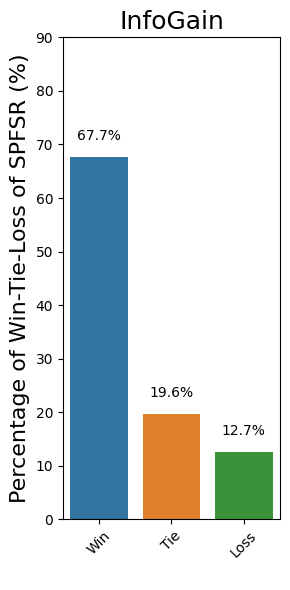

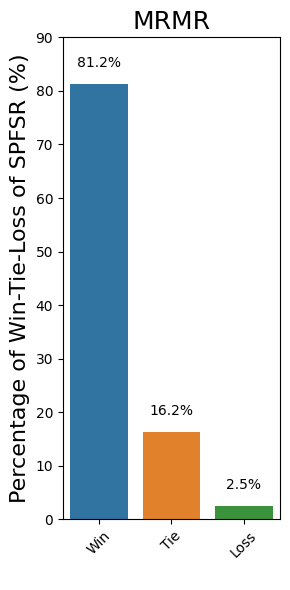

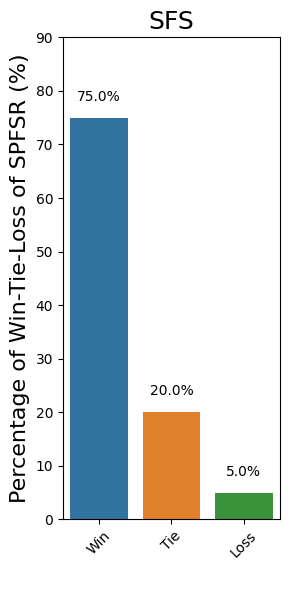

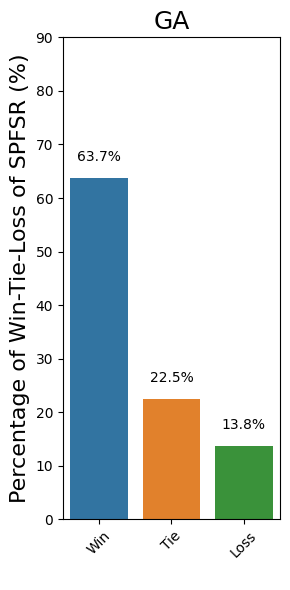

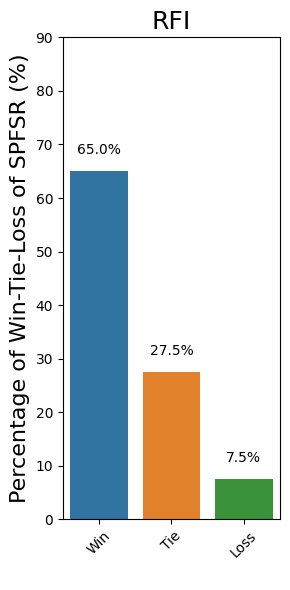

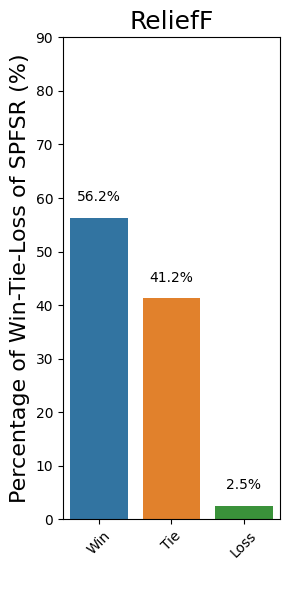

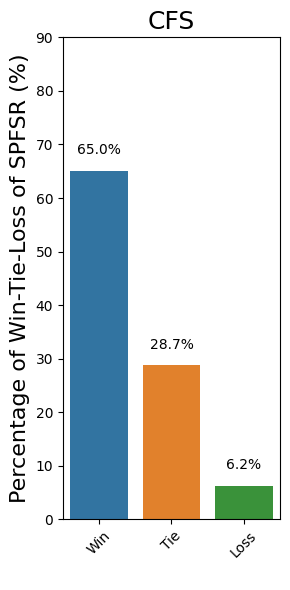

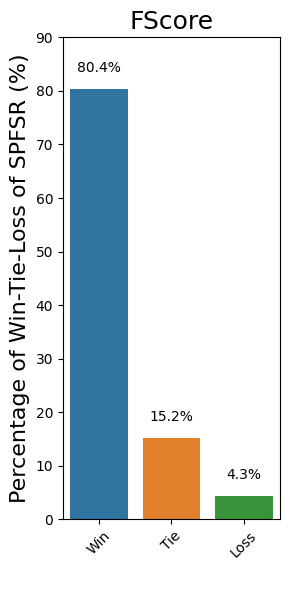

In [38]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the method summaries (use your actual method_summaries)

# Create a new folder for the plots
new_folder_name = "ttest_plots"
current_folder = os.getcwd()
new_folder_path = os.path.join(current_folder, new_folder_name)
if not os.path.exists(new_folder_path):
    os.makedirs(new_folder_path)

for method, counts in method_summaries.items():
    winner = counts.get('winner', 0)
    tie = counts.get('tie', 0)
    loss = counts.get('loss', 0)
    total = winner + tie + loss
    
    if total == 0:
        winner_percentage = tie_percentage = loss_percentage = 0
    else:
        winner_percentage = (winner / total) * 100
        tie_percentage = (tie / total) * 100
        loss_percentage = (loss / total) * 100
    
    data = {
        'Type': ['Win', 'Tie', 'Loss'],
        'Percentage': [winner_percentage, tie_percentage, loss_percentage]
    }
    FONT_SIZE = 16 
    df = pd.DataFrame(data)
    y_text = 'Percentage of Win-Tie-Loss of SPFSR (%)'
    plt.figure(figsize=(3, 6))
    ax = sns.barplot(x='Type', y='Percentage', data=df, palette='tab10')
    plt.title(f"{method}", fontsize=FONT_SIZE+2)
    plt.ylabel(y_text, fontsize=FONT_SIZE)
    plt.xlabel(' ')
    plt.xticks(rotation=45)
    
    # Set the y-axis limits using ax.set_ylim
    ax.set_ylim(0, 90)
    
    # Add data labels to the bars
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', xytext=(0, 10), textcoords='offset points')
    
    plt.tight_layout()  # Adjust spacing between subplots
    
    # Save the plot as PNG and EPS
    plot_filename = f"{method}_ttest_plot"
    plot_filepath_png = os.path.join(new_folder_path, f"{plot_filename}.png")
    plot_filepath_eps = os.path.join(new_folder_path, f"{plot_filename}.eps") 
    
    plt.savefig(plot_filepath_png, format='png', dpi=300)
    plt.savefig(plot_filepath_eps, format='eps')
    
    plt.show()
